In [ ]:
'''
Usage:
1. Data directory must be in the same directory as the script
2. Images, lables and superpixels directories must be inside data directory
3. Script parameters must be specified in script parameters cell
'''

In [1]:
import numpy as np
import os
import collections
import matplotlib.pyplot as plt
import skimage.future.graph as skigraph
import shutil
import pickle
import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import time
from kgcnn.literature.GNNExplain import GNNExplainer, GNNInterface
from kgcnn.literature.GCN import make_model
from kgcnn.utils.data import ragged_tensor_from_nested_numpy
from kgcnn.utils.learning import LinearLearningRateScheduler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import cdist
from sklearn.cluster import AgglomerativeClustering
from kgcnn.data.datasets.mutagenicity import MutagenicityDataset

In [6]:
# script parameters
MAIN_DIR_PATH = "/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint"
DATA_DIR_NAME = "data"
IMAGES_DIR_NAME = "images"
LABELS_DIR_NAME = "labels"
SUPERPIXELS_DIR_NAME = "superpixels"

IMAGE_FILE_PREFIX = "STIR"
SUPERPIXELS_FILE_PREFIX = "1000SuperPixelMeanValueTPS_"

IMG_CMAP = "pink"
EDGE_CMAP = "viridis"
EDGE_WIDTH = 2

# globals
DATA_DIR_PATH = f"{MAIN_DIR_PATH}/{DATA_DIR_NAME}"
IMAGES_DIR_PATH = f"{DATA_DIR_PATH}/{IMAGES_DIR_NAME}"
LABELS_DIR_PATH = f"{DATA_DIR_PATH}/{LABELS_DIR_NAME}"
SUPERPIXELS_DIR_PATH = f"{DATA_DIR_PATH}/{SUPERPIXELS_DIR_NAME}"

In [7]:
# utils
def show_2d_image_from_3d_image(image_3d, index_of_2d_image):
    plt.figure(figsize = (20,20))
    plt.imshow(image_3d[:,:,index_of_2d_image], cmap='gray')
    plt.show()
    
def save_object(filename, obj):
    obj_file = open(filename, 'wb')
    pickle.dump(obj, obj_file)
    obj_file.close()
    
def load_object(filename):
    obj_file = open(filename, 'rb')
    obj = pickle.load(obj_file)
    obj_file.close()
    
    return obj

# read data
def read_binary_data_3D(file_name, image_size, image_count, voxel_bytes, signed='Y', byte_order='BE'):
    if voxel_bytes == 2:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint16)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int16)
    elif voxel_bytes == 1:
        if signed == 'N':
            d = np.zeros((image_size, image_size, image_count), np.uint8)
        else:
            d = np.zeros((image_size, image_size, image_count), np.int8)
    else:
        print('Wrong number of bytes per voxel')
        return

    f = open(file_name, "rb")
    for i in range(0, image_count):
        for j in range(0, image_size):
            for k in range(0, image_size):
                byte = f.read(voxel_bytes)
                if voxel_bytes == 2:
                    if byte_order == 'BE':
                        a = 256 * byte[0] + byte[1]
                    else:
                        a = byte[0] + 256 * byte[1]
                else:
                    a = byte[0]
                d[j,k,i] = a
    f.close()
    return d

# rag creation
FileInfo = collections.namedtuple('FileInfo', ['name', 'patient_id', 'height', 'width', 'image_count', 'voxel_bytes'])

def create_rag_on_superpixels_image(labels, superpixels, rag, file_info, image_number, edge_width, img_cmap, edge_cmap):
    PATIENT_ID_DIR_PATH = f"{DATA_DIR_PATH}/rags/{file_info.patient_id}"
    RAG_IMAGE_PATH = f"{PATIENT_ID_DIR_PATH}/rag_{image_number}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.png"
    if os.path.exists(RAG_IMAGE_PATH):
        shutil.rmtree(PATIENT_ID_DIR_PATH)
    os.makedirs(PATIENT_ID_DIR_PATH, exist_ok=True)
    
    rag_file = open(RAG_IMAGE_PATH, "w")
    rag_file.close()
    
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 20))
    ax.axis('off')
    lc = skigraph.show_rag(
        labels, rag, superpixels, img_cmap=img_cmap, edge_width=edge_width, edge_cmap=edge_cmap, ax=ax
    )
    fig.colorbar(lc, fraction=0.04, ax=ax)
    fig.savefig(RAG_IMAGE_PATH)
    plt.close(fig) 
    
def assign_label(image, labels, rag):
    white_pixels_count = {}
    total_pixels_count = {}
    for (i, row) in enumerate(labels):
        for (j, label) in enumerate(row):
            if label in total_pixels_count:
                total_pixels_count[label] += 1
            else:
                total_pixels_count[label] = 1 
            if image[i][j] >= 130:
                if label in white_pixels_count:
                    white_pixels_count[label] += 1
                else:
                    white_pixels_count[label] = 1
    for (i, node) in enumerate(rag):
        if i in white_pixels_count and white_pixels_count[i] / total_pixels_count[i] >= 0.75:
            rag.nodes[node]['label'] = '1'
        else:
            rag.nodes[node]['label'] = '0'
            
def process_given_3D_image(labels_file, image_file, superpixels_file, file_info):
    rags = []
    
    for labels_index in range(file_info.image_count):
        print(f"Processing sub images: {labels_index + 1}/{file_info.image_count}")
        labels = labels_file[:,:,labels_index]
        img = image_file[:,:,labels_index]
        img = img/(img.max()/255.0)     
        rag = skigraph.rag_mean_color(img, labels)
        rags.append(rag)
        assign_label(img, labels, rag)
        superpixels = superpixels_file[:,:,labels_index]
        '''
        create_rag_on_superpixels_image(
           labels, superpixels, rag, file_info, labels_index + 1, EDGE_WIDTH, IMG_CMAP, EDGE_CMAP
        )
        '''
        
    return rags

def process_all_3D_images_from_directory(images_dir_path, labels_dir_path, superpixels_dir_path):
    file_names = os.listdir(labels_dir_path)
    rags = {i: list() for i in range(1, len(file_names) + 1)}

    for (file_3d_index, file_name) in enumerate(file_names, start=1):
        unprocessed_file_info = file_name.split("_")[:-1]
        unprocessed_file_info[1:] = [int(unprocessed_file_info[i]) for i in range(1, len(unprocessed_file_info))]
        file_info = FileInfo(*unprocessed_file_info)
        file_suffix = f"{file_info.patient_id}_{file_info.height}_{file_info.width}_{file_info.image_count}_{file_info.voxel_bytes}_.raw"
        print(f"Directory processing progress: {file_3d_index}/{len(file_names)}, current patient: {file_info.patient_id}")
        
        labels_file = read_binary_data_3D(
            f"{labels_dir_path}/{file_name}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        image_file = read_binary_data_3D(
            f"{images_dir_path}/{IMAGE_FILE_PREFIX}_{file_suffix}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='BE'
        )
        superpixels_file = read_binary_data_3D(
            f"{superpixels_dir_path}/{SUPERPIXELS_FILE_PREFIX}{file_suffix}",
            file_info.height,
            file_info.image_count,
            file_info.voxel_bytes,
            signed='Y',
            byte_order='EB'
        )
        
        rags[file_info.patient_id] = process_given_3D_image(labels_file, image_file, superpixels_file, file_info)
    
    print("All 3D files have been processed")
    return rags

# split into subgraphs containing node and node neighbors
def split_into_subgraphs(rags, how_many):
    neighbor_graphs = []
    labels = []
    for (i, rag_3d) in enumerate(rags.values()):
        if i ==  how_many:
            break
        print(i)
        for rag_2d in rag_3d:
            for node in rag_2d.nodes:
                nodes = [n for n in rag_2d.neighbors(node)]
                nodes.append(node)
                neighbor_graphs.append(rag_2d.subgraph(nodes))
                labels.append([float(rag_2d.nodes[node]['label'])])
    return neighbor_graphs, labels

def prepare_data(neighbor_graphs):
    nodes = []
    edge_indices = []
    edges = []
    for graph in neighbor_graphs:
        mean_intensities = []
        edges_prim = []
        for node in graph.nodes:
            mean_intensities.append(graph.nodes[node]['mean color'][0])  
        for data in graph.edges.data():
            edges_prim.append(data[2]['weight'])
        nodes.append(mean_intensities)
        edges.append(edges_prim)
        edge_indices.append(normalize_edge_indices([list(e) for e in graph.edges]))
    return nodes, edge_indices, edges

def normalize_edge_indices(edge_indices):
    result = []
    flat_list = []
    for sublist in edge_indices:
        for item in sublist:
            flat_list.append(item)
            
    flat_list.sort()
    flat_list = list(dict.fromkeys(flat_list))
    change = {key:value for (value, key) in enumerate(flat_list)}
    
    for sublist in edge_indices:
        temp = []
        for item in sublist:
            temp.append(change[item])
        result.append(temp)    
    
    
    return result

In [ ]:
rags = process_all_3D_images_from_directory(IMAGES_DIR_PATH, LABELS_DIR_PATH, SUPERPIXELS_DIR_PATH)

In [10]:
neighbor_graphs, labels = split_into_subgraphs(rags, 7)

0
1
2
3
4
5
6


In [12]:
save_object('rags', rags)
save_object('neighbor_graphs', neighbor_graphs)
save_object('labels', labels)
save_object('nodes', nodes)
save_object('edges', edges)
save_object('edge_indices', edge_indices)

In [9]:
rags = load_object('rags')

In [ ]:
neighbor_graphs = load_object('neighbor_graphs')

In [16]:
nodes = load_object('nodes')
edges = load_object('edges')
edge_indices = load_object('edge_indices')
labels = load_object('labels')

In [11]:
nodes, edge_indices, edges =  prepare_data(neighbor_graphs)

In [17]:
for i in range(len(labels)):
    edges[i] = np.expand_dims(edges[i], axis=-1).astype(np.float32) # Make edge feature dimension
for i in range(len(labels)):
    nodes[i] =np.expand_dims(nodes[i],axis=-1).astype(np.int) # Make One-Hot encoding

labels_train, labels_test, nodes_train, nodes_test, edges_train, edges_test, edge_indices_train, edge_indices_test = train_test_split(labels, nodes, edges, edge_indices,  train_size=0.8, random_state=1)

nodes_train = ragged_tensor_from_nested_numpy(nodes_train)
edges_train = ragged_tensor_from_nested_numpy(edges_train)
edge_indices_train = ragged_tensor_from_nested_numpy(edge_indices_train)

nodes_test = ragged_tensor_from_nested_numpy(nodes_test)
edges_test = ragged_tensor_from_nested_numpy(edges_test)
edge_indices_test = ragged_tensor_from_nested_numpy(edge_indices_test)

xtrain = nodes_train, edges_train, edge_indices_train
xtest = nodes_test, edges_test, edge_indices_test
ytrain = np.array(labels_train)
ytest = np.array(labels_test)
print([x.shape for x in xtrain])
print([x.shape for x in xtest])
print(ytrain.shape, ytest.shape)

[TensorShape([121148, None, 1]), TensorShape([121148, None, 1]), TensorShape([121148, None, 2])]
[TensorShape([30288, None, 1]), TensorShape([30288, None, 1]), TensorShape([30288, None, 2])]
(121148, 1) (30288, 1)


INFO:kgcnn: Updated model kwargs:
{'depth': 3,
 'gcn_args': {'activation': 'relu',
              'has_unconnected': True,
              'is_sorted': False,
              'normalize_by_weights': False,
              'pooling_method': 'mean',
              'units': 64,
              'use_bias': True},
 'input_embedding': {'edge': {'input_dim': 10, 'output_dim': 64},
                     'node': {'input_dim': 55, 'output_dim': 64}},
 'inputs': [{'dtype': 'float32',
             'name': 'node_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'float32',
             'name': 'edge_attributes',
             'ragged': True,
             'shape': (None, 1)},
            {'dtype': 'int64',
             'name': 'edge_indices',
             'ragged': True,
             'shape': (None, 2)}],
 'name': 'GCN',
 'output_embedding': 'graph',
 'output_mlp': {'activation': ['relu', 'relu', 'sigmoid'],
                'units': [140, 70, 1],
                'u

/home/daniel/anaconda3/lib/python3.8/site-packages/tensorflow/python/framework/indexed_slices.py:432: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  warnings.warn(


3786/3786 - 10s - loss: 284.2035 - accuracy: 0.8913
Epoch 2/150
3786/3786 - 10s - loss: 1.6809 - accuracy: 0.9784
Epoch 3/150
3786/3786 - 10s - loss: 0.0621 - accuracy: 0.9849
Epoch 4/150
3786/3786 - 10s - loss: 0.1697 - accuracy: 0.9849
Epoch 5/150
3786/3786 - 10s - loss: 20.8610 - accuracy: 0.9839
Epoch 6/150
3786/3786 - 10s - loss: 0.0549 - accuracy: 0.9856
Epoch 7/150
3786/3786 - 10s - loss: 7.8177 - accuracy: 0.9842
Epoch 8/150
3786/3786 - 10s - loss: 0.0563 - accuracy: 0.9853
Epoch 9/150
3786/3786 - 10s - loss: 0.0547 - accuracy: 0.9855
Epoch 10/150
3786/3786 - 12s - loss: 0.0806 - accuracy: 0.9854 - val_loss: 0.0552 - val_accuracy: 0.9863
Epoch 11/150
3786/3786 - 10s - loss: 0.7037 - accuracy: 0.9845
Epoch 12/150
3786/3786 - 10s - loss: 0.0546 - accuracy: 0.9856
Epoch 13/150
3786/3786 - 10s - loss: 0.0545 - accuracy: 0.9855
Epoch 14/150
3786/3786 - 10s - loss: 56.4973 - accuracy: 0.9841
Epoch 15/150
3786/3786 - 11s - loss: 0.0549 - accuracy: 0.9856
Epoch 16/150
3786/3786 - 10s -

Epoch 122/150
3786/3786 - 11s - loss: 0.5538 - accuracy: 0.9854
Epoch 123/150
3786/3786 - 11s - loss: 7.6005 - accuracy: 0.9854
Epoch 124/150
3786/3786 - 11s - loss: 1.7189 - accuracy: 0.9854
Epoch 125/150
3786/3786 - 10s - loss: 31.6766 - accuracy: 0.9854
Epoch 126/150
3786/3786 - 11s - loss: 0.5739 - accuracy: 0.9847
Epoch 127/150
3786/3786 - 12s - loss: 0.5492 - accuracy: 0.9854
Epoch 128/150
3786/3786 - 11s - loss: 0.5155 - accuracy: 0.9854
Epoch 129/150
3786/3786 - 11s - loss: 32.7223 - accuracy: 0.9854
Epoch 130/150
3786/3786 - 13s - loss: 0.5560 - accuracy: 0.9854 - val_loss: 0.5596 - val_accuracy: 0.9863
Epoch 131/150
3786/3786 - 12s - loss: 0.5558 - accuracy: 0.9854
Epoch 132/150
3786/3786 - 11s - loss: 0.5556 - accuracy: 0.9854
Epoch 133/150
3786/3786 - 11s - loss: 0.5536 - accuracy: 0.9854
Epoch 134/150
3786/3786 - 10s - loss: 503.4768 - accuracy: 0.9853
Epoch 135/150
3786/3786 - 10s - loss: 0.5582 - accuracy: 0.9854
Epoch 136/150
3786/3786 - 11s - loss: 0.5916 - accuracy: 0

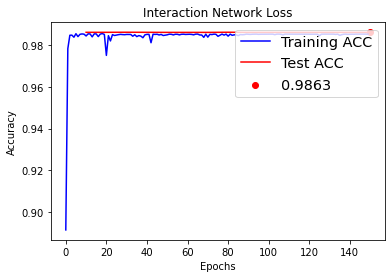

In [10]:
model = make_model(
    name = "GCN",
    inputs = [{'shape': (None, 1), 'name': "node_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 1), 'name': "edge_attributes", 'dtype': 'float32', 'ragged': True},
            {'shape': (None, 2), 'name': "edge_indices", 'dtype': 'int64', 'ragged': True}],
    input_embedding = {"node": {"input_dim": 55, "output_dim": 64},
                       "edge": {"input_dim": 10, "output_dim": 64}},

    output_embedding =  'graph',
    output_mlp = {"use_bias": [True, True, False], "units": [140, 70, 1],
                "activation": ['relu', 'relu', 'sigmoid']},
    gcn_args = {"units": 64, "use_bias": True, "activation": 'relu', "pooling_method": 'mean', 
                "normalize_by_weights": False},
)

# Set learning rate and epochs
learning_rate_start = 1e-3
learning_rate_stop = 1e-4
epo = 150
epomin = 100
epostep = 10

# Compile model with optimizer and loss
optimizer = tf.keras.optimizers.Adam(lr=learning_rate_start)
cbks = LinearLearningRateScheduler(learning_rate_start, learning_rate_stop, epomin, epo)
model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              weighted_metrics=['accuracy'])
print(model.summary())

# Start and time training
start = time.process_time()
hist = model.fit(xtrain, ytrain,
                 epochs=epo,
                 batch_size=32,
                 callbacks=[cbks],
                 validation_freq=epostep,
                 validation_data=(xtest, ytest),
                 verbose=2
                 )
stop = time.process_time()
print("Print Time for taining: ", stop - start)

# Get loss from history
trainlossall = np.array(hist.history['accuracy'])
testlossall = np.array(hist.history['val_accuracy'])
acc_valid = testlossall[-1]

# Plot loss vs epochs
plt.figure()
plt.plot(np.arange(trainlossall.shape[0]), trainlossall, label='Training ACC', c='blue')
plt.plot(np.arange(epostep, epo + epostep, epostep), testlossall, label='Test ACC', c='red')
plt.scatter([trainlossall.shape[0]], [acc_valid], label="{0:0.4f} ".format(acc_valid), c='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Interaction Network Loss')
plt.legend(loc='upper right', fontsize='x-large')
plt.savefig('gcn_explain_mutag.png')
plt.show()

In [11]:
model.save('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint')

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: /home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint/assets


In [2]:
model = keras.models.load_model('/home/daniel/Praca inżynierska/DetectingInflammationsInImagesOfSacroiliacJoint')

In [30]:
import sys
np.set_printoptions(threshold=sys.maxsize)
result = np.round(model.predict(xtest))
print(result)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.

In [31]:
result = model.predict(xtest)
import sys
np.set_printoptions(threshold=sys.maxsize)
print(result)

[[0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [1.96851790e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [0.00000000e+00]
 [5.00000000e-01]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [2.46888149e-14]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [6.68110180e-14]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [0.00000000e+00]
 [0.00000000e+00]
 [1.10498667e-02]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.32630980e-02]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.43232150e-14]
 [5.00000000e-01]
 [5.00000000e-01]
 [3.54628265e-02]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.00000000e-01]
 [0.00000000e+00]
 [5.00000000e-01]
 [5.00000000e-01]
 [5.000000

In [13]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(ytest)

[[0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.]
 [0.